# Stepik churn prediction

Цель: проанализировать активность студентов курса "[Анализ данных в R](https://stepik.org/course/129/promo)" на степике. На основе данных за первые 2 дня предсказать, закончит ли человек курс или бросит его. Курс считается пройденным, если решено не менее 40 задач.

## Описание данных
**events_data** - данные о действиях, которые совершают студенты со стэпами.
1. step_id - id стэпа
2. user_id - анонимизированный id юзера
3. timestamp - время наступления события в формате unix date
4. action - событие, возможные значения: 
    * discovered - пользователь перешел на стэп
    * viewed - просмотр шага
    * started_attempt - начало попытки решить шаг (ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага)
    * passed - удачное решение практического шага

**submissions_data** - данные о времени и статусах сабмитов к практическим заданиям

1. step_id - id стэпа
2. timestamp - время отправки решения в формате unix date
3. submission_status - статус решения
4. user_id - анонимизированный id юзера

Данные уже поделены на train и test. В test файлах предтавлены данные только о первых 2 днях прохождения курса.

# Анализ данных
## Предобработка данных

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (9, 6)})

Загрузим данные и посмотрим на них.

In [2]:
events_data = pd.read_csv('data/events_data_train.csv')

In [3]:
submissions_data = pd.read_csv('data/submissions_data_train.csv')

In [4]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [5]:
events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480703 entries, 0 to 3480702
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   step_id    int64 
 1   timestamp  int64 
 2   action     object
 3   user_id    int64 
dtypes: int64(3), object(1)
memory usage: 106.2+ MB


In [6]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [7]:
submissions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509104 entries, 0 to 509103
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   step_id            509104 non-null  int64 
 1   timestamp          509104 non-null  int64 
 2   submission_status  509104 non-null  object
 3   user_id            509104 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 15.5+ MB


In [8]:
events_data['action'].unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

Переведем дату из unix формата в нормальный вид.

In [9]:
events_data['date'] = pd.to_datetime(events_data['timestamp'], unit='s')
submissions_data['date'] = pd.to_datetime(submissions_data['timestamp'], unit='s')

In [10]:
events_data.head(5)

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


Посмотрим, какой период рассматривается в датасете.

In [11]:
events_data['date'].min(), events_data['date'].max()

(Timestamp('2015-06-15 04:00:48'), Timestamp('2018-05-19 23:33:31'))

В обучающей выборке имеем данные со старта курса (с 2015 года) до мая 2018 года.

Для удобства создадим колонку day, в которую поместим дату (без времени).

In [12]:
events_data['day'] = events_data['date'].dt.date
submissions_data['day'] = submissions_data['date'].dt.date

In [13]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Посмотрим, сколько студентов проходили курс в каждый день.

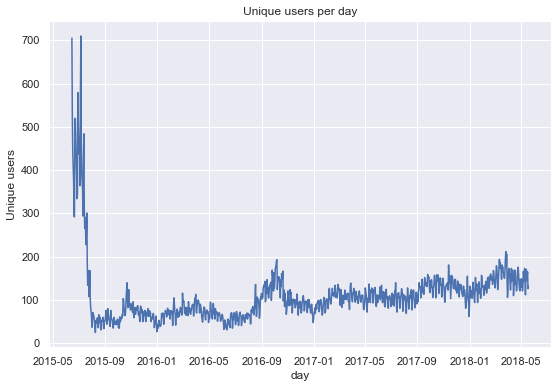

In [14]:
events_data.groupby('day')['user_id'].nunique().plot()
plt.xlabel('day')
plt.ylabel('Unique users')
plt.title('Unique users per day')
plt.show()

Видно, что в первые 3 месяца после открытия курса, его ежедневно посещало большое количество студентов. Затем ажиотаж спал, курс проходили ежедневно по 50-200 человек.

Посмотрим, какое количество каждого вида действий совершал каждый пользователь.

In [15]:
users_events_data = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [16]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


Посмотрим на распределение количества решенных задач.

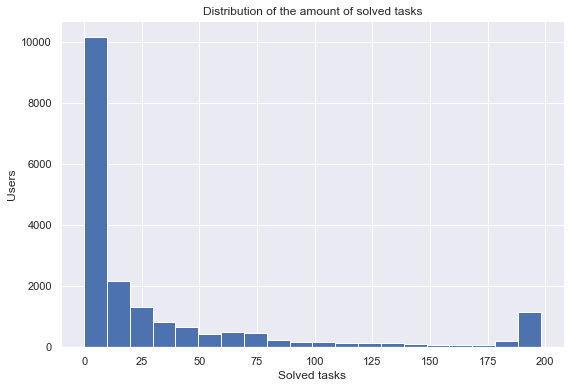

In [17]:
users_events_data['passed'].hist(bins=20)
plt.xlabel('Solved tasks')
plt.ylabel('Users')
plt.title('Distribution of the amount of solved tasks')
plt.show()

Картина довольно типичная для онлайн курсов. Значительное большинство либо решило не больше 10 задач, либо не притронулась к задачам вообще. До конца же доходит гораздо меньше студентов.

Дополнительно заметим, что чем больше задач решил студент, тем меньше вероятность того, что бросит курс.

## Feature Engineering
Теперь сделаем таблицу, в которую для каждого пользователя запишем количество правильных и неправильных ответов. Для этого обратимся к датасету submissions.

In [18]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [19]:
user_scores = submissions_data.pivot_table(index='user_id',
                            columns='submission_status',
                            values='step_id',
                            aggfunc='count',
                            fill_value=0).reset_index()

In [20]:
user_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Теперь нужно понять, как определять, бросил ли человек курс или нет. Для этого посмотрим на все промежутки времени между решениями задач для всех пользователей.

In [21]:
gap_data = events_data[['user_id', 'day', 'timestamp']] \
    .drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'] \
    .apply(list) \
    .apply(np.diff).values

In [22]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data.head()

0    4843602
1    6899249
2     182484
3      93710
4    2768870
dtype: int32

Мы получили значения перерывов в секундах. Для удобства переведем секунды в дни.

In [23]:
gap_data = gap_data / (24 * 60 * 60)

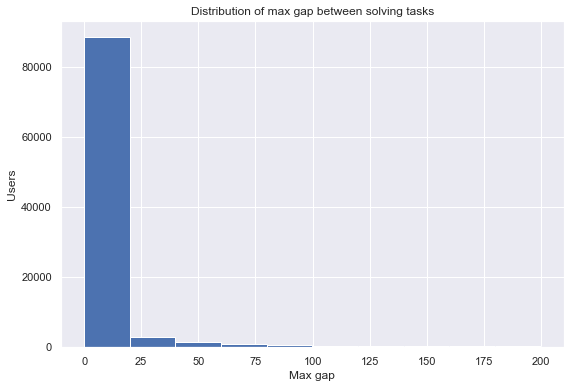

In [24]:
gap_data[gap_data < 200].hist()
plt.xlabel('Max gap')
plt.ylabel('Users')
plt.title('Distribution of max gap between solving tasks')
plt.show()

In [25]:
gap_data.quantile(0.95)

59.760440972222156

In [26]:
gap_data.quantile(0.90)

18.325995370370403

90% пользователей возвращаются к решению задач менее, чем через 18 дней. 95% пользователей возвращаются к курсу менее, чем через 2 месяца.

Возьмем пороговое значение, равное 30 дням - это между 90 и 95 перцентилем.

Теперь для каждого пользователя посмотрим, когда он в последний раз заходил на курс. Если это было больше месяца назад, то запишем, что он дропнулся.

In [27]:
events_data['date'].max()

Timestamp('2018-05-19 23:33:31')

*Предположим, что сегодня 19.05.2018*

In [28]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [29]:
now = events_data['timestamp'].max() # timestamp "сегодняшнего" дня
drop_out_threshold = 30 * 24 * 60 * 60

In [30]:
users_data['is_gone'] = (now - users_data['last_timestamp']) > drop_out_threshold

In [31]:
users_data.sample(5)

,user_id,last_timestamp,is_gone
2250,3074,1449247733,True
11792,16375,1474230267,True
11548,16049,1512146426,True
10116,14050,1497940779,True
4037,5592,1510674040,True


Теперь у нас есть три датасета о пользователях - один с количеством правильных ответов, другой - с информацией, дропнулся ли он или нет, третий - со статистикой по количеству совершенных действий. Объединим их в один.

In [32]:
user_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [33]:
users_data = users_data.merge(user_scores, on='user_id', how='outer').fillna(0)

In [34]:
users_data.head()

,user_id,last_timestamp,is_gone,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [35]:
users_data = users_data.merge(users_events_data, on='user_id', how='outer')

In [36]:
users_data.head()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


Важный признак - количество дней, которое пользователь потратил на прохождение курса. Добавим эту фичу в датасет.

In [37]:
users_days = events_data.groupby('user_id')['day'].nunique().to_frame().reset_index()

In [38]:
users_days.rename({'day': 'days_spent'}, axis=1, inplace=True)

In [39]:
users_days.head()

,user_id,days_spent
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [40]:
users_data = users_data.merge(users_days, on='user_id', how='outer')

In [41]:
users_data.head()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,days_spent
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


Также добавим фичу, которая покажет, прошел ли человек курс или нет. Для прохождения курса нужно набрать минимум 40 баллов.

In [42]:
users_data['passed_course'] = users_data['passed'] >= 40

In [43]:
users_data.head()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,days_spent,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,True
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


Посмотрим, какой процент студентов завершил курс.

In [44]:
passed_course_data = users_data.groupby('passed_course')['user_id'].count()
passed_course_data

passed_course
False    14482
True      4752
Name: user_id, dtype: int64

In [45]:
passed_course_data[True] / passed_course_data.sum() * 100

24.706249350109182

24,7% пользователей решили как минимум 40 заданий курса.

## Подготовка данных для обучения моделей

Наша цель - как можно раньше предсказать, когда пользователь дропнется с курса.

Посмотрим, сколько дней требуется пользователям для прохождения курса.

In [46]:
users_data[users_data['passed_course']]['days_spent'].median()

12.0

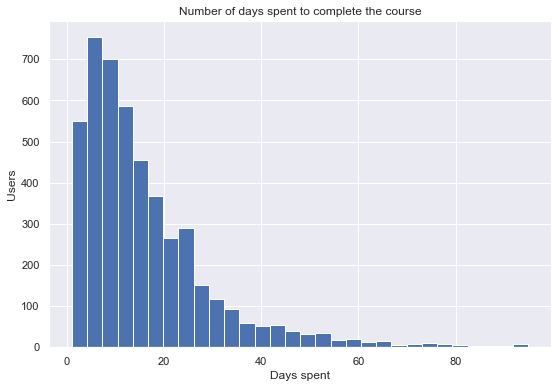

In [47]:
users_data[(users_data['passed_course']) & (users_data['days_spent'] < 100)]['days_spent'].hist(bins=30)
plt.xlabel('Days spent')
plt.ylabel('Users')
plt.title('Number of days spent to complete the course')
plt.show()

Посмотрим, можно ли по данным за 2 дня предсказать, дропнется ли человек с курса. Для этого нам необходимо взять из датасета events_data только данные о первых двух днях каждого юзера.

Для этого нам понадобится колонка с временем, когда пользователь начал проходить курс. Для этого мы для каждого пользователя найдем его минимальный timestamp.

In [48]:
events_data.head(1)

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15


In [49]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [50]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [51]:
users_data = users_data.merge(user_min_time, how='outer')

In [52]:
users_data.head()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,days_spent,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,True,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


Отберем только те действия, которые произошли в первые 2 дня обучения каждого пользователя.

In [53]:
learning_time_treshold = 2 * 24 * 60 * 60 # 2 дня в секундах
learning_time_treshold

172800

In [54]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [55]:
events_data = events_data.merge(user_min_time, on='user_id', how='outer')

In [56]:
events_data.rename({'min_timestamp': 'min_user_timestamp'}, axis=1, inplace=True)

In [57]:
events_data.sample()

,step_id,timestamp,action,user_id,date,day,min_user_timestamp
1264992,32089,1460190897,viewed,10411,2016-04-09 08:34:57,2016-04-09,1458471165


In [58]:
events_data_train = events_data.query('min_user_timestamp + @learning_time_treshold > timestamp')

Теперь мы достали данные о тех событиях, которые случились в первые 2 дня обучения.

In [59]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,min_user_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


In [60]:
events_data_train.shape

(906194, 7)

Проверим, что для каждого пользователя у нас присутствуют записи максимум за 3 дня:

In [61]:
events_data_train.groupby('user_id')['day'].nunique().max()

3

Продалаем аналогичные действия с submissions_data.

In [62]:
submissions_data = submissions_data.merge(user_min_time, on='user_id', how='outer')
submissions_data.rename({'min_timestamp': 'min_user_timestamp'}, axis=1, inplace=True)
submissions_data_train = submissions_data.query('min_user_timestamp + @learning_time_treshold > timestamp')
submissions_data_train.groupby('user_id')['day'].nunique().max()

3

In [63]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,min_user_timestamp
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,1434345977
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,1434345977
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434345977
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,1434345977
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,1434345977


Наконец, заведем датафрейм X, который будем наполнять данными для обучения модели. Добавим туда количество дней, потраченные на курс, количество попыток, долю правильных ответов и всю информацию, полученную ранее.

In [64]:
X = submissions_data_train.groupby('user_id')['day'].nunique().to_frame().reset_index() \
    .rename(columns={'day': 'days_spent'})

In [65]:
X.head()

,user_id,days_spent
0,2,1
1,3,1
2,8,1
3,14,1
4,16,2


In [66]:
steps_tried = submissions_data_train.groupby('user_id')['step_id'].nunique().to_frame().reset_index() \
    .rename(columns={'step_id': 'steps_tried'})

In [67]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [68]:
X.head(1)

,user_id,days_spent,steps_tried
0,2,1,2


In [69]:
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                            columns='submission_status',
                            values='step_id',
                            aggfunc='count',
                            fill_value=0).reset_index(), how='outer')

In [70]:
X['correct_ratio'] = X['correct'] / (X['correct'] + X['wrong'])

In [71]:
X.head(1)

,user_id,days_spent,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.0


In [72]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                            columns='action',
                            values='step_id',
                            aggfunc='count',
                            fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [73]:
X.shape

(19234, 7)

In [74]:
X.fillna(0, inplace=True)

In [75]:
X.head(1)

,user_id,days_spent,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.0,9


In [76]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone']], how='outer')

In [77]:
X.head()

,user_id,days_spent,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone
0,2,1.0,2.0,2.0,0.0,1.000000,9,False,True
1,3,1.0,4.0,4.0,4.0,0.500000,20,True,True
2,8,1.0,11.0,9.0,21.0,0.300000,154,True,True
3,14,1.0,1.0,0.0,1.0,0.000000,9,False,True
4,16,2.0,18.0,18.0,23.0,0.439024,117,True,True


После многочисленных объединений таблиц многие колонки из целочисенных превратились в вещественные. Проверим, все ли с ними в порядке и приведем обратно к нужному типу.

In [78]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19234 entries, 0 to 19233
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        19234 non-null  int64  
 1   days_spent     19234 non-null  float64
 2   steps_tried    19234 non-null  float64
 3   correct        19234 non-null  float64
 4   wrong          19234 non-null  float64
 5   correct_ratio  19234 non-null  float64
 6   viewed         19234 non-null  int64  
 7   passed_course  19234 non-null  bool   
 8   is_gone        19234 non-null  bool   
dtypes: bool(2), float64(5), int64(2)
memory usage: 1.2 MB


In [79]:
X['days_spent'].unique()

array([1., 2., 3., 0.])

In [80]:
X['steps_tried'].unique()

array([ 2.,  4., 11.,  1., 18., 15.,  7.,  6.,  3.,  9.,  8., 16., 27.,
       51.,  5., 28., 13., 12., 36., 17., 29., 10., 14., 25., 20., 26.,
       24., 31., 19., 40., 37., 23., 35., 34., 22., 62., 33., 30., 45.,
       46., 74., 50., 65., 21., 32., 38., 73., 68., 58., 67., 48., 41.,
       47., 54., 75., 76., 52., 56., 66., 64., 72., 43., 39.,  0.])

In [81]:
X['correct'].unique()

array([ 2.,  4.,  9.,  0., 18., 15.,  1.,  7.,  3.,  6.,  8., 11.,  5.,
       10., 27., 52., 26., 13., 28., 37., 17., 16., 14., 24., 36., 20.,
       25., 12., 33., 19., 41., 30., 42., 35., 23., 34., 60., 29., 45.,
       31., 21., 22., 48., 51., 39., 74., 49., 64., 46., 65., 32., 38.,
       73., 67., 40., 58., 50., 47., 44., 54., 75., 43., 76., 57., 66.,
       69., 72., 53.])

In [82]:
X['wrong'].unique()

array([  0.,   4.,  21.,   1.,  23.,   2.,   9.,  16.,   5.,   3.,   8.,
        27.,  10.,  24.,   7.,  12.,  54.,   6.,  13.,  32.,  18.,  15.,
        36.,  11.,  29.,  19.,  20.,  34.,  59.,  79.,  33.,  35.,  46.,
        42.,  73.,  14.,  17.,  52.,  30.,  55.,  25.,  49.,  28.,  26.,
        65.,  51.,  47., 118.,  50.,  95.,  48.,  75.,  53.,  31.,  22.,
        67.,  39., 173.,  37.,  45., 155.,  57.,  92.,  76.,  70.,  43.,
        72.,  64.,  44.,  56.,  38.,  41., 122.,  58.,  62.,  61., 105.,
        40.,  66.,  83.,  80.,  99., 131., 145.,  93.,  94.,  71., 152.,
        68.,  98.,  60.,  97., 101.,  96., 183.,  81.,  90.,  84.,  69.,
       103.,  87., 106., 100.,  82., 184.,  91.,  63., 120.])

In [83]:
X[['days_spent', 'steps_tried', 'correct', 'wrong']] = X[['days_spent', 'steps_tried', 'correct', 'wrong']].astype('int32', copy=False)

In [84]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19234 entries, 0 to 19233
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        19234 non-null  int64  
 1   days_spent     19234 non-null  int32  
 2   steps_tried    19234 non-null  int32  
 3   correct        19234 non-null  int32  
 4   wrong          19234 non-null  int32  
 5   correct_ratio  19234 non-null  float64
 6   viewed         19234 non-null  int64  
 7   passed_course  19234 non-null  bool   
 8   is_gone        19234 non-null  bool   
dtypes: bool(2), float64(1), int32(4), int64(2)
memory usage: 939.2 KB


Отберем только тех пользователей, которые уже либо закончили курс, либо уже бросили его.

In [85]:
X = X.query('is_gone or passed_course')

In [86]:
X.head()

,user_id,days_spent,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone
0,2,1,2,2,0,1.000000,9,False,True
1,3,1,4,4,4,0.500000,20,True,True
2,8,1,11,9,21,0.300000,154,True,True
3,14,1,1,0,1,0.000000,9,False,True
4,16,2,18,18,23,0.439024,117,True,True


Создадим вектор с целевой переменной.

In [87]:
y = X['passed_course'].map(int)

In [88]:
X.drop(['passed_course', 'is_gone'], axis=1, inplace=True)

In [89]:
X.head(1)

,user_id,days_spent,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1,2,2,0,1.0,9


In [90]:
X = X.set_index(X['user_id'])
X = X.drop('user_id', axis=1)

In [91]:
X.head()

,days_spent,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1,2,2,0,1.000000,9
3,1,4,4,4,0.500000,20
8,1,11,9,21,0.300000,154
14,1,1,0,1,0.000000,9
16,2,18,18,23,0.439024,117


## Подготовка тестовых данных

Тестовые данные обработаем аналогичным образом.

*TODO: сделать нормальный пайплайн обработки данных*

In [92]:
events_data_test = pd.read_csv('data/events_data_test.csv')
submissions_data_test = pd.read_csv('data/submissions_data_test.csv')

In [93]:
events_data_test['date'] = pd.to_datetime(events_data_test['timestamp'], unit='s')
submissions_data_test['date'] = pd.to_datetime(submissions_data_test['timestamp'], unit='s')

In [94]:
events_data_test['date'].min(), events_data_test['date'].max()

(Timestamp('2018-05-20 03:59:01'), Timestamp('2019-01-20 17:00:43'))

In [95]:
events_data_test['day'] = events_data_test['date'].dt.date
submissions_data_test['day'] = submissions_data_test['date'].dt.date

In [96]:
users_events_data_test = events_data_test.pivot_table(index='user_id', 
                            columns='action', 
                            values='step_id', 
                            aggfunc='count', 
                            fill_value=0).reset_index()

In [97]:
user_scores_test = submissions_data_test.pivot_table(index='user_id',
                                columns='submission_status',
                                values='step_id',
                                aggfunc='count',
                                fill_value=0).reset_index()

In [98]:
users_data_test = events_data_test.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [99]:
users_data_test = users_data_test.merge(user_scores_test, on='user_id', how='outer').fillna(0)

In [100]:
users_data_test = users_data_test.merge(users_events_data_test, on='user_id', how='outer')

In [101]:
users_days_test = events_data_test.groupby('user_id')['day'].nunique().to_frame().reset_index()
users_days_test.rename({'day': 'days_spent'}, axis=1, inplace=True)

In [102]:
users_data_test = users_data_test.merge(users_days_test, on='user_id', how='outer')

In [103]:
X_test = submissions_data_test.groupby('user_id')['day'].nunique().to_frame().reset_index() \
    .rename(columns={'day': 'days_spent'})

In [104]:
steps_tried_test = submissions_data_test.groupby('user_id')['step_id'].nunique().to_frame().reset_index() \
    .rename(columns={'step_id': 'steps_tried'})

X_test = X_test.merge(steps_tried_test, on='user_id', how='outer')

In [105]:
X_test = X_test.merge(submissions_data_test.pivot_table(index='user_id',
                            columns='submission_status',
                            values='step_id',
                            aggfunc='count',
                            fill_value=0).reset_index(), how='outer')

In [106]:
X_test['correct_ratio'] = X_test['correct'] / (X_test['correct'] + X_test['wrong'])

In [107]:
X_test = X_test.merge(events_data_test.pivot_table(index='user_id',
                            columns='action',
                            values='step_id',
                            aggfunc='count',
                            fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [108]:
X_test.fillna(0, inplace=True)

In [109]:
X_test[['days_spent', 'steps_tried', 'correct', 'wrong']] = X_test[['days_spent', 'steps_tried', 'correct', 'wrong']].astype('int32', copy=False)

In [110]:
X_test = X_test.set_index(X_test['user_id'])
X_test = X_test.drop('user_id', axis=1)

In [111]:
X_test.head()

,days_spent,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
12,1,1,1,0,1.000000,14
13,2,29,29,36,0.446154,105
15,3,11,10,30,0.250000,1
21,1,30,24,103,0.188976,98
35,3,9,7,35,0.166667,70


In [112]:
X_test.shape

(6184, 6)

# Обучение моделей

При обучении будем использовать метрику ROC-AUC.

In [113]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [114]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

### Функция для создания сабмита

In [115]:
def make_submit(file_name, y_pred):
    submit_df = pd.DataFrame([X_test.index, y_pred], index=['user_id', 'is_gone']).T
    submit_df['user_id'] = submit_df['user_id'].astype('int32', copy=False)
    submit_df.to_csv(file_name, index=False, header=True)

### Функция для обучения и проверки модели

In [116]:
def train(model, params, file_name, scale=False):
    if scale:
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

    model_gs = GridSearchCV(model,
                           params,
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1)
    if scale:
        model_gs.fit(X_train_scaled, y_train)
    else:
        model_gs.fit(X_train, y_train)
    print('Best params:', model_gs.best_params_)
    
    if scale:
        val_score = roc_auc_score(y_val, model_gs.predict_proba(X_val_scaled)[:, 1])
    else:
        val_score = roc_auc_score(y_val, model_gs.predict_proba(X_val)[:, 1])
    print('Val score:', val_score)
    
    if scale:
        y_pred = model_gs.predict_proba(X_test_scaled)
    else:
        y_pred = model_gs.predict_proba(X_test)

    make_submit(file_name, y_pred[:, 1])

## Logistic Regression

In [117]:
from sklearn.linear_model import LogisticRegression

In [118]:
lr = LogisticRegression()

In [119]:
params = {'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000]}

In [120]:
train(lr, params, 'lr.csv', scale=True)

Best params: {'C': 1}
Val score: 0.8722534979787275


ROC-AUC на тестовых данных: **0.8800175161101942**

## Random Forest

In [121]:
from sklearn.ensemble import RandomForestClassifier

In [122]:
rf = RandomForestClassifier()

In [123]:
params = {'n_estimators': range(10, 151, 10),
         'criterion': ['gini', 'entropy'],
         'max_depth': range(3, 8)}

In [124]:
train(rf, params, 'rf.csv')

Best params: {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 40}
Val score: 0.8732329810824601


ROC-AUC на тестовых данных: **0.8792803601036646**

## KNN
*а вдруг..*

In [125]:
from sklearn.neighbors import KNeighborsClassifier

In [126]:
knn = KNeighborsClassifier()

In [127]:
params = {'n_neighbors': range(1, 11),
         'weights': ['uniform', 'distance']}

In [128]:
train(knn, params, 'knn.csv')

Best params: {'n_neighbors': 10, 'weights': 'uniform'}
Val score: 0.8511733927940657


ROC-AUC на тестовых данных: **0.8292088061517822**

## Catboost

In [129]:
!pip install catboost

In [130]:
from catboost import CatBoostClassifier

In [131]:
cb = CatBoostClassifier(learning_rate=0.01, iterations=50, verbose=0)

In [132]:
cb.fit(X_train, y_train)

In [133]:
roc_auc_score(y_val, cb.predict_proba(X_val)[:, 1])

0.8679141400761412

In [134]:
y_pred = cb.predict_proba(X_test)[:, 1]
make_submit('cb.csv', y_pred)

ROC-AUC на тестовых данных: **0.8800778058454362**

# Выводы

Так как итоговый датасет получился довольно маленьким, то все использованные классические модели показали хорошие результаты.